#### **Dependencies**

In [64]:
# Importing Required Libraries and Modules
import os
import time
import copy
import random
import pickle
import importlib as lib
from collections import defaultdict
import json

# Data Manipulation and Configuration
import numpy as np
import pandas as pd
import yaml

# PyTorch Utilities
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset

# Image Processing Libraries
import cv2
import matplotlib.pyplot as plt
from matplotlib import rc
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda

# Utility Functions
from utils import mnist_dataset
from utils import dataset_getter as dat

# Metrics and Evaluation
from tqdm import tqdm

# Logic Layer Implementation
from difflogic import LogicLayer, GroupSum, PackBitsTensor
import difflogic_cuda

# Configuration Management with Hydra
from hydra import initialize, compose

In [33]:
# Display Available GPU Information
print(f"Detected GPUs: {torch.cuda.device_count()}")

Detected GPUs: 4


#### **Dataset**

In [35]:
# Dataset and Preprocessing Settings
crop = None  # cropping configuration: None removes no border, specify (x,x) for cropping dimensions
image_shape = (28, 28) 
dataset_name = "mnist" # "mnist" or "fashion_mnist" 
bpp = 1 # bits per pixel

# Ensuring Reproducibility Across Runs
# Seeds for Random Generators in PyTorch, NumPy, and Python
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# DataLoader Parameters
batch_size = 512
train_loader, test_loader, input_dim, out_dim = dat.get_dataset(
    dataset_name,
    batch_size=batch_size,
    data_dir="./data",
    bpp=bpp,
    crop=crop  
)

# Analyze and Balance Class Distribution in Dataset
train_targets = train_loader.dataset.targets
test_targets = test_loader.dataset.targets

# Class-Wise Sample Count
train_class_counts = [torch.sum(train_targets == i).item() for i in range(10)]
test_class_counts = [torch.sum(test_targets == i).item() for i in range(10)]

# Determine Minimum Samples Per Class for Balanced Dataset
min_samples_train = min(train_class_counts)
min_samples_test = min(test_class_counts)

# Define Function to Trim Datasets for Balance
def balance_dataset(dataset, targets, min_samples):
    indices = []
    for class_label in range(10):
        class_indices = (targets == class_label).nonzero(as_tuple=True)[0]
        indices.extend(class_indices[:min_samples])

    # Shuffle Indices to Randomize the Dataset
    indices = torch.tensor(indices)
    shuffled_indices = indices[torch.randperm(indices.size(0))]
    
    return Subset(dataset, shuffled_indices)

# Apply Balancing to Train and Test Datasets
balanced_train_dataset = balance_dataset(train_loader.dataset, train_targets, min_samples_train)
balanced_test_dataset = balance_dataset(test_loader.dataset, test_targets, min_samples_test)

# Re-Initialize DataLoaders with Balanced Datasets
train_loader_balanced = DataLoader(
    balanced_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True
)
test_loader_balanced = DataLoader(
    balanced_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True
)

# Verify New Dataset Sizes
print(f"Balanced Train Dataset Size: {len(train_loader_balanced.dataset)}")
print(f"Balanced Test Dataset Size: {len(test_loader_balanced.dataset)}")

# Update Loaders and Datasets for Subsequent Use
train_loader = train_loader_balanced
test_loader = test_loader_balanced

Balanced Train Dataset Size: 54210
Balanced Test Dataset Size: 8920


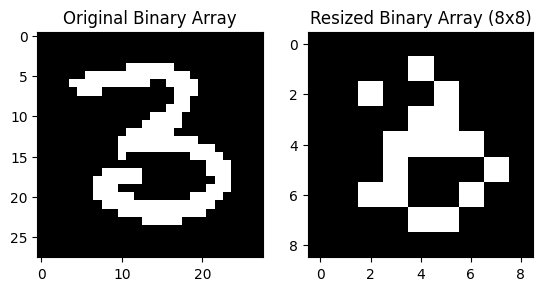

In [36]:
# Visualize a Random Image from the Balanced Training Dataset
data_index = random.randint(0, len(train_loader.dataset) - 1)
random_image, _ = train_loader.dataset[data_index]

# Process Image for Display
processed_image = np.array([
    np.sum([random_image[(i * bpp) + j] * (2 ** (bpp - j + 1)) for j in range(bpp)])
    for i in range(image_shape[0] * image_shape[0])
]).reshape(image_shape)

# Assume processed_image is your original binary (28x28) array
bool_arr = processed_image

# Resize using nearest neighbor interpolation to retain binary values
resized_binary = resize(bool_arr, (9, 9), order=0, preserve_range=True, anti_aliasing=False).astype(bool)

# Plot original and resized images
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(bool_arr, cmap='gray')
ax0.set_title('Original Binary Array')
ax1.imshow(resized_binary, cmap='gray')
ax1.set_title('Resized Binary Array (8x8)')
plt.show()

In [37]:
# Define the transformation function
def transform_image(image, image_shape, bpp, new_shape):
    # Process the image to convert it into a binary representation
    processed_image = np.array([
        np.sum([image[(i * bpp) + j] * (2 ** (bpp - j + 1)) for j in range(bpp)])
        for i in range(image_shape[0] * image_shape[1])
    ]).reshape(image_shape)
    
    # Resize the binary image using nearest neighbor interpolation
    resized_binary = resize(
        processed_image, new_shape, order=0, preserve_range=True, anti_aliasing=False
    ).astype(bool)
    
    return resized_binary

# Define the function to apply the transformation to the entire dataset
def transform_dataset(dataset, image_shape, bpp, new_shape):
    transformed_data = []
    transformed_targets = []
    
    for image, label in dataset:
        resized_binary = transform_image(image, image_shape, bpp, new_shape)
        transformed_data.append(resized_binary)
        transformed_targets.append(label)
    
    return np.array(transformed_data), np.array(transformed_targets)

In [65]:
# Apply the transformation to the balanced training and test datasets
new_shape = (9, 9)  # Resize to 9x9
transformed_train_data, transformed_train_targets = transform_dataset(
    train_loader.dataset, image_shape, bpp, new_shape
)
transformed_test_data, transformed_test_targets = transform_dataset(
    test_loader.dataset, image_shape, bpp, new_shape
)

ValueError: too many values to unpack (expected 2)

Transformed Train Data Shape: (54210, 9, 9)
Transformed Test Data Shape: (8920, 9, 9)


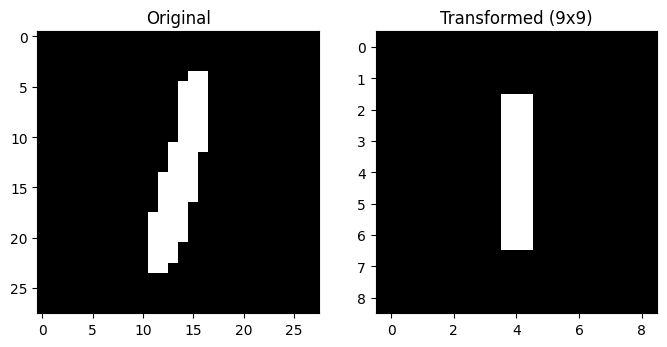

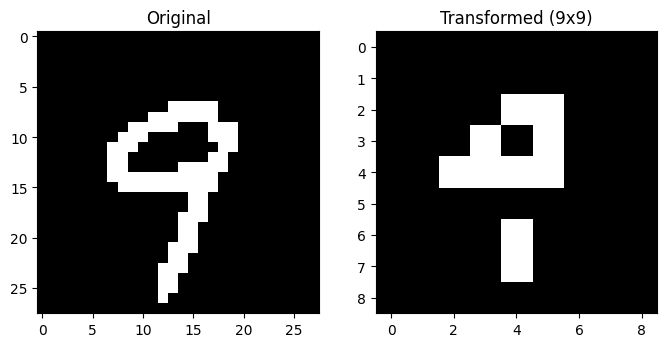

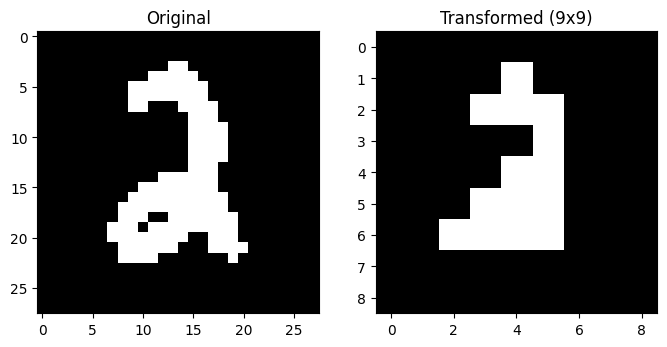

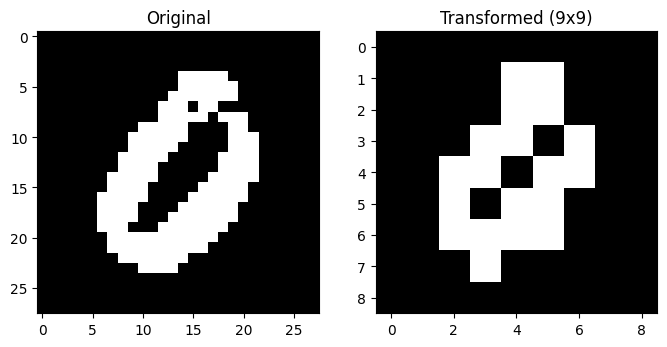

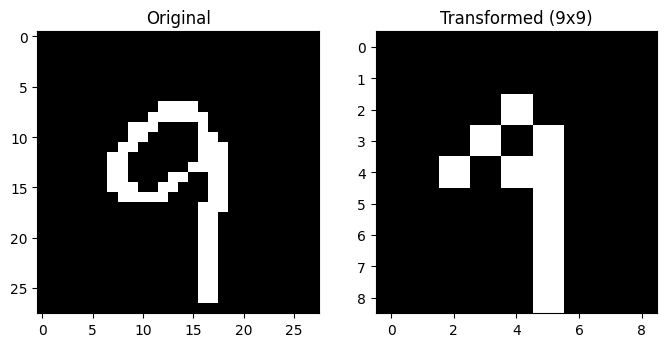

In [39]:
# Verify the shapes of transformed datasets
print(f"Transformed Train Data Shape: {transformed_train_data.shape}")
print(f"Transformed Test Data Shape: {transformed_test_data.shape}")

# Optional: Visualize a few examples
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(train_loader.dataset[i][0].numpy().reshape(image_shape), cmap='gray')
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_train_data[i], cmap='gray')
    plt.title("Transformed (9x9)")
    plt.show()

#### **Model Hyperparameters**

Converts csv into yaml config file

In [52]:
if new_shape == (9,9):
    dataset_name = "mnist_mini"
    image_shape = (9,9)
    
# define first input and the name of the file to be saved
if dataset_name == "mnist":
    first_in_dim = 400*bpp
    filename = "config/mnist_config_20x20.yaml"
    df = pd.read_csv("config/mnist_hyperparameters.csv")
elif dataset_name == "mnist_mini":
    first_in_dim = 81*bpp
    filename = "config/mnist_mini_config_9x9.yaml"
    df = pd.read_csv("config/mnist_mini_hyperparameters.csv")   
elif dataset_name == "fashion_mnist":
    first_in_dim = 784*bpp
    filename = "config/fashion_mnist_config_28x28.yaml"
    df = pd.read_csv("config/fashion_mnist_hyperparameters.csv")

In [53]:
# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/mnist_mini_config_9x9.yaml' generated successfully.


#### **Model Function Declarations**

In [73]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        #x = torch.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model', model_cfg=None):
        """
        Saves the model's state dictionary plus all relevant architecture info
        to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model.
            model_cfg (dict): The full dictionary that contains layer config,
                              output_size, tau, learning rate, etc.
        """
        checkpoint_data = {
            'model_state_dict': self.state_dict(),
            'connections': [
                layer.indices 
                for layer in self.logic_layers 
                if isinstance(layer, LogicLayer)
            ],
            # Store the entire config so you can reconstruct everything
            'model_config': {
                'layers_config': model_cfg['layers_config'],
                'output_size': model_cfg['output_size'],
                'tau': model_cfg['tau'],
                'learning_rate': model_cfg.get('learning_rate', None),
            }
        }

        # Now dump that all out to disk
        torch.save(checkpoint_data, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"


    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')
                
                # flattens
                batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)

                # forward pass to get predictions
                outputs = self(batch_inputs.float())

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [55]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### **Training**

In [66]:
if image_shape == (9,9):  
    # Convert data and targets to PyTorch tensors
    transformed_train_data_tensor = torch.tensor(transformed_train_data, dtype=torch.float32)
    transformed_train_targets_tensor = torch.tensor(transformed_train_targets, dtype=torch.long)
    transformed_test_data_tensor = torch.tensor(transformed_test_data, dtype=torch.float32)
    transformed_test_targets_tensor = torch.tensor(transformed_test_targets, dtype=torch.long)

    # Combine data and labels into TensorDatasets
    train_dataset = TensorDataset(transformed_train_data_tensor, transformed_train_targets_tensor)
    test_dataset = TensorDataset(transformed_test_data_tensor, transformed_test_targets_tensor)

    # Create DataLoaders
    batch_size = 512  # Adjust as needed
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True
    )

In [77]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="Visualizer"):
    cfg = compose(config_name=f"{dataset_name}_config_{image_shape[0]}x{image_shape[0]}")

# training loop for all models
all_models_dict = {}
num_epochs = 100 # just for debugging
file_path = f'trained_models/{dataset_name}_trained_models' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    # initializes DiffLogic model and moves to CUDA if available
    model = DiffLogic(layers_config=model_cfg['layers_config'], 
                      output_size=model_cfg['output_size'], 
                      tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')

    # wraps the model with DataParallel to distribute workload across GPUs 
    #model = torch.nn.DataParallel(model)
    
    # optimizer and loss criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
    criterion = nn.CrossEntropyLoss()

    # early stopping
    early_stopper = EarlyStopper(patience=5)

    print('model', model)

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
        epoch_loss = 0  # to track loss for an epoch            

        for batch_inputs, batch_outputs in loop:
            # move data to the appropriate device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

            # flattens
            batch_inputs = batch_inputs.view(batch_inputs.size(0), -1)
            
            # forward pass through the model
            predictions = model(batch_inputs)  
                        
            loss = criterion(predictions, batch_outputs)
            
            # zero gradients, backpropagates, and updates model parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # accumulating the loss for the epoch
            epoch_loss += loss.item()

        # caclulating the average loss for the epoch
        epoch_loss /= len(train_loader)
        all_models_dict[model_name]['losses'].append(epoch_loss)
        print(f'Epoch {epoch+1} Loss: {epoch_loss}')

        # checks for early stopping
        if early_stopper.should_stop(epoch_loss):
            print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
            break

    # saving trained model's state
    model.save(file_path, model_name, model_cfg=model_cfg)

print("All models processed.")

training model model_001
LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, train)
    (1): LogicLayer(50, 50, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 184.61it/s]


Epoch 1 Loss: 2.293937155572481


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 256.75it/s]


Epoch 2 Loss: 2.262447711051238


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 256.39it/s]


Epoch 3 Loss: 2.244114677425954


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 208.49it/s]


Epoch 4 Loss: 2.23573510722509


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 259.31it/s]


Epoch 5 Loss: 2.23111392770752


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 261.07it/s]


Epoch 6 Loss: 2.2290930912185845


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 261.22it/s]


Epoch 7 Loss: 2.228211267604242


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 259.14it/s]


Epoch 8 Loss: 2.2277438764584945


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 260.12it/s]


Epoch 9 Loss: 2.2274541032011204


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 259.09it/s]


Epoch 10 Loss: 2.2271541122480865


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 208.15it/s]


Epoch 11 Loss: 2.2270343368746994


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 258.70it/s]


Epoch 12 Loss: 2.22690544639608


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 257.43it/s]


Epoch 13 Loss: 2.2267745280046483


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 259.40it/s]


Epoch 14 Loss: 2.2267608636713834


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 206.67it/s]


Epoch 15 Loss: 2.226750545355804


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 258.66it/s]


Epoch 16 Loss: 2.2266963558278436


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 258.67it/s]


Epoch 17 Loss: 2.226619433921042


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 206.46it/s]


Epoch 18 Loss: 2.2265657968059043


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 258.61it/s]


Epoch 19 Loss: 2.2264620769576102


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 256.45it/s]


Epoch 20 Loss: 2.226466633229477
EarlyStopper Triggered:  1


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 258.36it/s]


Epoch 21 Loss: 2.226420287506776


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 206.03it/s]


Epoch 22 Loss: 2.226453059703455
EarlyStopper Triggered:  1


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 256.67it/s]


Epoch 23 Loss: 2.226265671960302


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 257.70it/s]


Epoch 24 Loss: 2.225019600151978


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 206.01it/s]


Epoch 25 Loss: 2.224918617831969


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 256.16it/s]


Epoch 26 Loss: 2.22488668454145


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 256.30it/s]


Epoch 27 Loss: 2.2248402716011224


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 255.75it/s]


Epoch 28 Loss: 2.2247941358867336


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 256.78it/s]


Epoch 29 Loss: 2.2248291095485464
EarlyStopper Triggered:  1


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 255.71it/s]


Epoch 30 Loss: 2.224808992859773
EarlyStopper Triggered:  2


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 256.56it/s]


Epoch 31 Loss: 2.22361397638663


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 198.77it/s]


Epoch 32 Loss: 2.2230601925502773


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 257.39it/s]


Epoch 33 Loss: 2.222968581454449


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 258.47it/s]


Epoch 34 Loss: 2.2230259578797114
EarlyStopper Triggered:  1


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 257.93it/s]


Epoch 35 Loss: 2.2230040430674323
EarlyStopper Triggered:  2


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 208.52it/s]


Epoch 36 Loss: 2.22293820013734


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 259.34it/s]


Epoch 37 Loss: 2.223004996871005
EarlyStopper Triggered:  1


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 260.18it/s]


Epoch 38 Loss: 2.2229986737840255
EarlyStopper Triggered:  2


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 260.32it/s]


Epoch 39 Loss: 2.2229973456533925
EarlyStopper Triggered:  3


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 258.86it/s]


Epoch 40 Loss: 2.223004387046122
EarlyStopper Triggered:  4


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 260.31it/s]


Epoch 41 Loss: 2.222916708822839


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 259.65it/s]


Epoch 42 Loss: 2.2229443248349328
EarlyStopper Triggered:  1


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 201.84it/s]


Epoch 43 Loss: 2.2229103877902743


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 258.72it/s]


Epoch 44 Loss: 2.2229467039462216
EarlyStopper Triggered:  1


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 256.28it/s]


Epoch 45 Loss: 2.222900477221797


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 254.16it/s]


Epoch 46 Loss: 2.223014014099059
EarlyStopper Triggered:  1


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 259.78it/s]


Epoch 47 Loss: 2.2229848313815195
EarlyStopper Triggered:  2


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 260.42it/s]


Epoch 48 Loss: 2.2229544902435636
EarlyStopper Triggered:  3


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 260.98it/s]


Epoch 49 Loss: 2.2228945028824105


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 204.54it/s]


Epoch 50 Loss: 2.222968822558664
EarlyStopper Triggered:  1


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 259.56it/s]


Epoch 51 Loss: 2.2229801452659137
EarlyStopper Triggered:  2


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 259.27it/s]


Epoch 52 Loss: 2.222921161117086
EarlyStopper Triggered:  3


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 207.58it/s]


Epoch 53 Loss: 2.222895256980889
EarlyStopper Triggered:  4


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 258.86it/s]


Epoch 54 Loss: 2.2229001072106964
EarlyStopper Triggered:  5
Early stopping triggered for model_001 at epoch 54.
training model model_002
LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, train)
    (1): LogicLayer(50, 50, train)
    (2): LogicLayer(50, 50, train)
    (3): LogicLayer(50, 50, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 189.73it/s]


Epoch 1 Loss: 2.299804838557493


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 205.89it/s]


Epoch 2 Loss: 2.254021752069306


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 171.77it/s]


Epoch 3 Loss: 2.2055212945924882


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 206.52it/s]


Epoch 4 Loss: 2.190944432746131


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 196.77it/s]


Epoch 5 Loss: 2.1855485207756487


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 205.51it/s]


Epoch 6 Loss: 2.182624645578789


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 204.65it/s]


Epoch 7 Loss: 2.1813719945418786


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 206.29it/s]


Epoch 8 Loss: 2.1803984311916107


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 205.43it/s]


Epoch 9 Loss: 2.179310572507818


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 172.62it/s]


Epoch 10 Loss: 2.1787772162361763


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 205.32it/s]


Epoch 11 Loss: 2.17844704711256


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 205.98it/s]


Epoch 12 Loss: 2.1782983591336533


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 171.53it/s]


Epoch 13 Loss: 2.1780634095956146


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 205.82it/s]


Epoch 14 Loss: 2.177961334194815


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 206.69it/s]


Epoch 15 Loss: 2.1779549353372665


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 206.81it/s]


Epoch 16 Loss: 2.1778626078192063


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 171.74it/s]


Epoch 17 Loss: 2.177732983855353


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 205.58it/s]


Epoch 18 Loss: 2.177602723042692


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 205.20it/s]


Epoch 19 Loss: 2.1774162734506386


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 205.18it/s]


Epoch 20 Loss: 2.177248376759


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 204.57it/s]


Epoch 21 Loss: 2.1770761523396223


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 203.56it/s]


Epoch 22 Loss: 2.1770407058483725


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 204.33it/s]


Epoch 23 Loss: 2.177002747347274


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 170.90it/s]


Epoch 24 Loss: 2.1769373420644422


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 204.88it/s]


Epoch 25 Loss: 2.1768802403889826


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 205.85it/s]


Epoch 26 Loss: 2.1768497393401987


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 205.22it/s]


Epoch 27 Loss: 2.1767953150717285


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 206.84it/s]


Epoch 28 Loss: 2.17672202948346


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 206.18it/s]


Epoch 29 Loss: 2.1767564815897225
EarlyStopper Triggered:  1


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 172.88it/s]


Epoch 30 Loss: 2.1767400409276028
EarlyStopper Triggered:  2


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 203.94it/s]


Epoch 31 Loss: 2.1766494908518483


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 205.67it/s]


Epoch 32 Loss: 2.1766752520735193
EarlyStopper Triggered:  1


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 205.15it/s]


Epoch 33 Loss: 2.176737630706884
EarlyStopper Triggered:  2


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 206.71it/s]


Epoch 34 Loss: 2.1766285577317355


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 205.96it/s]


Epoch 35 Loss: 2.176696394114869
EarlyStopper Triggered:  1


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 207.66it/s]


Epoch 36 Loss: 2.176637907504454
EarlyStopper Triggered:  2


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 172.44it/s]


Epoch 37 Loss: 2.1766213443104125


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 207.79it/s]


Epoch 38 Loss: 2.1766389915776965
EarlyStopper Triggered:  1


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 206.51it/s]


Epoch 39 Loss: 2.176581871496749


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 207.95it/s]


Epoch 40 Loss: 2.1765917155386347
EarlyStopper Triggered:  1


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 206.78it/s]


Epoch 41 Loss: 2.17671475255379
EarlyStopper Triggered:  2


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 207.45it/s]


Epoch 42 Loss: 2.176622093213463
EarlyStopper Triggered:  3


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 206.27it/s]


Epoch 43 Loss: 2.176610542651759
EarlyStopper Triggered:  4


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 173.22it/s]


Epoch 44 Loss: 2.1766267112258033
EarlyStopper Triggered:  5
Early stopping triggered for model_002 at epoch 44.
training model model_003
LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, train)
    (1): LogicLayer(50, 50, train)
    (2): LogicLayer(50, 50, train)
    (3): LogicLayer(50, 50, train)
    (4): LogicLayer(50, 50, train)
    (5): LogicLayer(50, 50, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 171.57it/s]


Epoch 1 Loss: 2.302622633245244


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 172.34it/s]


Epoch 2 Loss: 2.27933424319873


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 171.70it/s]


Epoch 3 Loss: 2.2034980194012417


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 147.75it/s]


Epoch 4 Loss: 2.1662029146041184


Epoch 5/100: 100%|██████████| 105/105 [00:01<00:00, 97.05it/s]


Epoch 5 Loss: 2.1541554719911487


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 158.60it/s]


Epoch 6 Loss: 2.149907748834388


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 170.85it/s]


Epoch 7 Loss: 2.147329886450594


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 171.62it/s]


Epoch 8 Loss: 2.1458325917082113


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 171.20it/s]


Epoch 9 Loss: 2.144570315482675


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 172.21it/s]


Epoch 10 Loss: 2.143505147807053


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 144.32it/s]


Epoch 11 Loss: 2.1429686066936244


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 170.48it/s]


Epoch 12 Loss: 2.1423232997660224


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 171.35it/s]


Epoch 13 Loss: 2.141380573359686


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 147.24it/s]


Epoch 14 Loss: 2.140437634429095


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 171.24it/s]


Epoch 15 Loss: 2.139996744766759


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 172.18it/s]


Epoch 16 Loss: 2.139825968342773


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 171.88it/s]


Epoch 17 Loss: 2.1396583287174273


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 172.56it/s]


Epoch 18 Loss: 2.1396039455840814


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 171.95it/s]


Epoch 19 Loss: 2.1393976947258055


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 172.70it/s]


Epoch 20 Loss: 2.1391391956521115


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 147.21it/s]


Epoch 21 Loss: 2.1385765910422463


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 170.14it/s]


Epoch 22 Loss: 2.137827340254339


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 171.09it/s]


Epoch 23 Loss: 2.1375118836315927


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 170.80it/s]


Epoch 24 Loss: 2.1374761048206214


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 147.63it/s]


Epoch 25 Loss: 2.13739794215604


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 171.62it/s]


Epoch 26 Loss: 2.137234070623696


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 172.00it/s]


Epoch 27 Loss: 2.1371233748270453


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 172.35it/s]


Epoch 28 Loss: 2.1371209446106003


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 172.11it/s]


Epoch 29 Loss: 2.1369553241044494


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 172.79it/s]


Epoch 30 Loss: 2.1369701551296765
EarlyStopper Triggered:  1


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 172.08it/s]


Epoch 31 Loss: 2.136859545980203


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 147.78it/s]


Epoch 32 Loss: 2.1367257881062462


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 172.54it/s]


Epoch 33 Loss: 2.136599262409325


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 171.77it/s]


Epoch 34 Loss: 2.1365807903191416


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 172.32it/s]


Epoch 35 Loss: 2.1364672965172993


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 171.46it/s]


Epoch 36 Loss: 2.1362289698246415


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 172.16it/s]


Epoch 37 Loss: 2.135945915670332


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 171.06it/s]


Epoch 38 Loss: 2.1351622509702954


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 146.76it/s]


Epoch 39 Loss: 2.1348518084507075


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 171.87it/s]


Epoch 40 Loss: 2.1346510867164983


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 171.19it/s]


Epoch 41 Loss: 2.134753047533811
EarlyStopper Triggered:  1


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 171.85it/s]


Epoch 42 Loss: 2.1347744110740137
EarlyStopper Triggered:  2


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 171.04it/s]


Epoch 43 Loss: 2.1347447243940096
EarlyStopper Triggered:  3


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 171.30it/s]


Epoch 44 Loss: 2.134640991923218


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 147.52it/s]


Epoch 45 Loss: 2.134741161289095
EarlyStopper Triggered:  1


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 170.42it/s]


Epoch 46 Loss: 2.1347087637106523
EarlyStopper Triggered:  2


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 171.56it/s]


Epoch 47 Loss: 2.13462680633096


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 171.10it/s]


Epoch 48 Loss: 2.1346288161002924
EarlyStopper Triggered:  1


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 171.36it/s]


Epoch 49 Loss: 2.1346084388663153


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 171.27it/s]


Epoch 50 Loss: 2.1345435988274137


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 170.68it/s]


Epoch 51 Loss: 2.13460758993959
EarlyStopper Triggered:  1


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 147.38it/s]


Epoch 52 Loss: 2.134603110120534
EarlyStopper Triggered:  2


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 169.81it/s]


Epoch 53 Loss: 2.134534383643393


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 170.37it/s]


Epoch 54 Loss: 2.1344604734909223


Epoch 55/100: 100%|██████████| 105/105 [00:00<00:00, 170.20it/s]


Epoch 55 Loss: 2.134449951316575


Epoch 56/100: 100%|██████████| 105/105 [00:00<00:00, 146.22it/s]


Epoch 56 Loss: 2.134473714784913
EarlyStopper Triggered:  1


Epoch 57/100: 100%|██████████| 105/105 [00:00<00:00, 170.66it/s]


Epoch 57 Loss: 2.1344856887940487
EarlyStopper Triggered:  2


Epoch 58/100: 100%|██████████| 105/105 [00:00<00:00, 170.15it/s]


Epoch 58 Loss: 2.1344110473919464


Epoch 59/100: 100%|██████████| 105/105 [00:00<00:00, 145.11it/s]


Epoch 59 Loss: 2.1344383481568805
EarlyStopper Triggered:  1


Epoch 60/100: 100%|██████████| 105/105 [00:00<00:00, 170.42it/s]


Epoch 60 Loss: 2.134476233674403
EarlyStopper Triggered:  2


Epoch 61/100: 100%|██████████| 105/105 [00:00<00:00, 170.00it/s]


Epoch 61 Loss: 2.1344289989929837
EarlyStopper Triggered:  3


Epoch 62/100: 100%|██████████| 105/105 [00:00<00:00, 170.53it/s]


Epoch 62 Loss: 2.1344193586295086
EarlyStopper Triggered:  4


Epoch 63/100: 100%|██████████| 105/105 [00:00<00:00, 146.16it/s]


Epoch 63 Loss: 2.13446952276761
EarlyStopper Triggered:  5
Early stopping triggered for model_003 at epoch 63.
training model model_004
LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, train)
    (1): LogicLayer(50, 50, train)
    (2): LogicLayer(50, 50, train)
    (3): LogicLayer(50, 50, train)
    (4): LogicLayer(50, 50, train)
    (5): LogicLayer(50, 50, train)
    (6): LogicLayer(50, 50, train)
    (7): LogicLayer(50, 50, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 134.22it/s]


Epoch 1 Loss: 2.3026832386555016


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 146.46it/s]


Epoch 2 Loss: 2.2919967288131877


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 146.25it/s]


Epoch 3 Loss: 2.212447664136419


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 146.41it/s]


Epoch 4 Loss: 2.1694191912667278


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 147.05it/s]


Epoch 5 Loss: 2.155689988717354


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 146.78it/s]


Epoch 6 Loss: 2.1501387549537876


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 128.50it/s]


Epoch 7 Loss: 2.147254851365202


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 147.01it/s]


Epoch 8 Loss: 2.1452193084726656


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 147.13it/s]


Epoch 9 Loss: 2.1424776273813313


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 146.89it/s]


Epoch 10 Loss: 2.1405865799384025


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 147.09it/s]


Epoch 11 Loss: 2.1396888460795553


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 147.19it/s]


Epoch 12 Loss: 2.13831351459715


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 146.33it/s]


Epoch 13 Loss: 2.137064237950611


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 128.46it/s]


Epoch 14 Loss: 2.135615364324153


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 146.75it/s]


Epoch 15 Loss: 2.1347916489665977


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 146.19it/s]


Epoch 16 Loss: 2.1342385451467805


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 128.44it/s]


Epoch 17 Loss: 2.1338314516847405


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 146.84it/s]


Epoch 18 Loss: 2.133789246729378


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 147.31it/s]


Epoch 19 Loss: 2.1336933196160177


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 147.65it/s]


Epoch 20 Loss: 2.133543088741963


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 147.65it/s]


Epoch 21 Loss: 2.1332238143254663


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 147.77it/s]


Epoch 22 Loss: 2.1329737161176405


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 147.63it/s]


Epoch 23 Loss: 2.1328615597281955


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 129.38it/s]


Epoch 24 Loss: 2.132752876544433


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 147.42it/s]


Epoch 25 Loss: 2.1324245317149866


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 147.52it/s]


Epoch 26 Loss: 2.1322634358505


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 147.72it/s]


Epoch 27 Loss: 2.1303059819727124


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 147.65it/s]


Epoch 28 Loss: 2.1293501404511437


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 147.34it/s]


Epoch 29 Loss: 2.1291832409328526


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 147.49it/s]


Epoch 30 Loss: 2.1289069402228993


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 129.14it/s]


Epoch 31 Loss: 2.1285053162828382


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 147.22it/s]


Epoch 32 Loss: 2.12826238714731


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 147.22it/s]


Epoch 33 Loss: 2.128203537920532


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 147.22it/s]


Epoch 34 Loss: 2.128150431925788


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 147.06it/s]


Epoch 35 Loss: 2.128186692316153
EarlyStopper Triggered:  1


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 146.06it/s]


Epoch 36 Loss: 2.128132972003532


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 145.79it/s]


Epoch 37 Loss: 2.1261343951574085


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 128.06it/s]


Epoch 38 Loss: 2.1257149544555403


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 145.94it/s]


Epoch 39 Loss: 2.1254971545819146


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 146.17it/s]


Epoch 40 Loss: 2.1251131517023842


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 146.89it/s]


Epoch 41 Loss: 2.1247622423294157


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 146.56it/s]


Epoch 42 Loss: 2.1246163039213237


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 146.76it/s]


Epoch 43 Loss: 2.1246462755749556
EarlyStopper Triggered:  1


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 147.45it/s]


Epoch 44 Loss: 2.124583386039184


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 128.77it/s]


Epoch 45 Loss: 2.124344495953129


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 146.75it/s]


Epoch 46 Loss: 2.12429641695075


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 147.01it/s]


Epoch 47 Loss: 2.124246567259386


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 147.08it/s]


Epoch 48 Loss: 2.1243408666357744
EarlyStopper Triggered:  1


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 146.83it/s]


Epoch 49 Loss: 2.1242675710300425
EarlyStopper Triggered:  2


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 146.97it/s]


Epoch 50 Loss: 2.1241884203507415


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 147.11it/s]


Epoch 51 Loss: 2.1242317279261402
EarlyStopper Triggered:  1


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 127.74it/s]


Epoch 52 Loss: 2.124277508288149
EarlyStopper Triggered:  2


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 145.92it/s]


Epoch 53 Loss: 2.1242267561911294
EarlyStopper Triggered:  3


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 146.40it/s]


Epoch 54 Loss: 2.124128734887173


Epoch 55/100: 100%|██████████| 105/105 [00:00<00:00, 128.30it/s]


Epoch 55 Loss: 2.124067266917912


Epoch 56/100: 100%|██████████| 105/105 [00:00<00:00, 146.34it/s]


Epoch 56 Loss: 2.124060971502675


Epoch 57/100: 100%|██████████| 105/105 [00:00<00:00, 147.12it/s]


Epoch 57 Loss: 2.1241087071835123
EarlyStopper Triggered:  1


Epoch 58/100: 100%|██████████| 105/105 [00:00<00:00, 146.97it/s]


Epoch 58 Loss: 2.1239483596630744


Epoch 59/100: 100%|██████████| 105/105 [00:00<00:00, 147.01it/s]


Epoch 59 Loss: 2.123292187974516


Epoch 60/100: 100%|██████████| 105/105 [00:00<00:00, 147.12it/s]


Epoch 60 Loss: 2.123224274230337


Epoch 61/100: 100%|██████████| 105/105 [00:00<00:00, 146.78it/s]


Epoch 61 Loss: 2.1233349001584254
EarlyStopper Triggered:  1


Epoch 62/100: 100%|██████████| 105/105 [00:00<00:00, 128.82it/s]


Epoch 62 Loss: 2.1233082677778636
EarlyStopper Triggered:  2


Epoch 63/100: 100%|██████████| 105/105 [00:00<00:00, 146.65it/s]


Epoch 63 Loss: 2.1232598052427787
EarlyStopper Triggered:  3


Epoch 64/100: 100%|██████████| 105/105 [00:00<00:00, 147.15it/s]


Epoch 64 Loss: 2.123244365517437
EarlyStopper Triggered:  4


Epoch 65/100: 100%|██████████| 105/105 [00:00<00:00, 146.48it/s]


Epoch 65 Loss: 2.1231775476932926


Epoch 66/100: 100%|██████████| 105/105 [00:00<00:00, 146.57it/s]


Epoch 66 Loss: 2.1231266601722596


Epoch 67/100: 100%|██████████| 105/105 [00:00<00:00, 146.84it/s]


Epoch 67 Loss: 2.122794085550147


Epoch 68/100: 100%|██████████| 105/105 [00:00<00:00, 146.39it/s]


Epoch 68 Loss: 2.1227708564708303


Epoch 69/100: 100%|██████████| 105/105 [00:00<00:00, 128.52it/s]


Epoch 69 Loss: 2.1227854807541915
EarlyStopper Triggered:  1


Epoch 70/100: 100%|██████████| 105/105 [00:00<00:00, 146.81it/s]


Epoch 70 Loss: 2.122664878796369


Epoch 71/100: 100%|██████████| 105/105 [00:00<00:00, 146.20it/s]


Epoch 71 Loss: 2.1228125775044924
EarlyStopper Triggered:  1


Epoch 72/100: 100%|██████████| 105/105 [00:00<00:00, 146.48it/s]


Epoch 72 Loss: 2.1226948089368687
EarlyStopper Triggered:  2


Epoch 73/100: 100%|██████████| 105/105 [00:00<00:00, 147.03it/s]


Epoch 73 Loss: 2.1227569259843917
EarlyStopper Triggered:  3


Epoch 74/100: 100%|██████████| 105/105 [00:00<00:00, 140.84it/s]


Epoch 74 Loss: 2.122806794634894
EarlyStopper Triggered:  4


Epoch 75/100: 100%|██████████| 105/105 [00:00<00:00, 146.32it/s]


Epoch 75 Loss: 2.1228323022364712
EarlyStopper Triggered:  5
Early stopping triggered for model_004 at epoch 75.
training model model_005
LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, train)
    (1): LogicLayer(50, 50, train)
    (2): LogicLayer(50, 50, train)
    (3): LogicLayer(50, 50, train)
    (4): LogicLayer(50, 50, train)
    (5): LogicLayer(50, 50, train)
    (6): LogicLayer(50, 50, train)
    (7): LogicLayer(50, 50, train)
    (8): LogicLayer(50, 50, train)
    (9): LogicLayer(50, 50, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:01<00:00, 102.12it/s]


Epoch 1 Loss: 2.302714514602776


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 127.81it/s]


Epoch 2 Loss: 2.302293704205897


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 127.74it/s]


Epoch 3 Loss: 2.27192221915619


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 127.94it/s]


Epoch 4 Loss: 2.2098789662064897


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 128.01it/s]


Epoch 5 Loss: 2.183151389725574


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 128.33it/s]


Epoch 6 Loss: 2.17766300399751


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 128.52it/s]


Epoch 7 Loss: 2.174394569153293


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 114.32it/s]


Epoch 8 Loss: 2.172281823017088


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 128.34it/s]


Epoch 9 Loss: 2.1712561793713423


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 128.26it/s]


Epoch 10 Loss: 2.169733575571798


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 114.44it/s]


Epoch 11 Loss: 2.168512999699311


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 128.66it/s]


Epoch 12 Loss: 2.1679581543680064


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 128.20it/s]


Epoch 13 Loss: 2.167596981454476


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 128.34it/s]


Epoch 14 Loss: 2.1673905300591096


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 114.23it/s]


Epoch 15 Loss: 2.166863243218781


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 128.48it/s]


Epoch 16 Loss: 2.1665140990964082


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 128.50it/s]


Epoch 17 Loss: 2.165686875557519


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 128.20it/s]


Epoch 18 Loss: 2.1652844868087473


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 128.34it/s]


Epoch 19 Loss: 2.164428288591313


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 128.31it/s]


Epoch 20 Loss: 2.1636677061917977


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 128.44it/s]


Epoch 21 Loss: 2.163345631684086


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 113.54it/s]


Epoch 22 Loss: 2.1631409834012074


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 128.14it/s]


Epoch 23 Loss: 2.162716151951491


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 128.01it/s]


Epoch 24 Loss: 2.162604795706824


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 128.16it/s]


Epoch 25 Loss: 2.162488578746159


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 128.19it/s]


Epoch 26 Loss: 2.1624282767904486


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 127.99it/s]


Epoch 27 Loss: 2.162417161385789


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 114.01it/s]


Epoch 28 Loss: 2.1623478371253344


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 126.89it/s]


Epoch 29 Loss: 2.162335040983881


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 127.27it/s]


Epoch 30 Loss: 2.1623856788440823
EarlyStopper Triggered:  1


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 126.91it/s]


Epoch 31 Loss: 2.1623163289450464


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 127.09it/s]


Epoch 32 Loss: 2.1616497558954184


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 127.46it/s]


Epoch 33 Loss: 2.1606596698660447


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 127.37it/s]


Epoch 34 Loss: 2.1597133416836134


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 113.62it/s]


Epoch 35 Loss: 2.1589504324243847


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 126.99it/s]


Epoch 36 Loss: 2.1587910481510324


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 126.22it/s]


Epoch 37 Loss: 2.158719828005735


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 127.78it/s]


Epoch 38 Loss: 2.1586254646320904


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 127.95it/s]


Epoch 39 Loss: 2.157860180335377


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 128.27it/s]


Epoch 40 Loss: 2.157754396973836


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 128.25it/s]


Epoch 41 Loss: 2.157693930360396


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 114.46it/s]


Epoch 42 Loss: 2.157651540496789


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 128.06it/s]


Epoch 43 Loss: 2.1577327931691874
EarlyStopper Triggered:  1


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 128.73it/s]


Epoch 44 Loss: 2.1575350680195644


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 128.36it/s]


Epoch 45 Loss: 2.157447751095069


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 128.45it/s]


Epoch 46 Loss: 2.15697736623067


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 128.58it/s]


Epoch 47 Loss: 2.1568189668017834


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 128.74it/s]


Epoch 48 Loss: 2.156893833831592
EarlyStopper Triggered:  1


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 114.81it/s]


Epoch 49 Loss: 2.155918966930967


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 128.53it/s]


Epoch 50 Loss: 2.1555663923182267


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 128.38it/s]


Epoch 51 Loss: 2.154153308909211


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 128.52it/s]


Epoch 52 Loss: 2.1539034306520866


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 128.89it/s]


Epoch 53 Loss: 2.1539096471978825
EarlyStopper Triggered:  1


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 128.28it/s]


Epoch 54 Loss: 2.1532505846582484


Epoch 55/100: 100%|██████████| 105/105 [00:00<00:00, 128.41it/s]


Epoch 55 Loss: 2.152803308084473


Epoch 56/100: 100%|██████████| 105/105 [00:00<00:00, 114.43it/s]


Epoch 56 Loss: 2.1526634829523204


Epoch 57/100: 100%|██████████| 105/105 [00:00<00:00, 128.38it/s]


Epoch 57 Loss: 2.152732132268991
EarlyStopper Triggered:  1


Epoch 58/100: 100%|██████████| 105/105 [00:00<00:00, 128.65it/s]


Epoch 58 Loss: 2.152631887723055


Epoch 59/100: 100%|██████████| 105/105 [00:00<00:00, 128.29it/s]


Epoch 59 Loss: 2.1527898567818773
EarlyStopper Triggered:  1


Epoch 60/100: 100%|██████████| 105/105 [00:00<00:00, 128.26it/s]


Epoch 60 Loss: 2.1526667553879615
EarlyStopper Triggered:  2


Epoch 61/100: 100%|██████████| 105/105 [00:00<00:00, 128.41it/s]


Epoch 61 Loss: 2.1525449999541353


Epoch 62/100: 100%|██████████| 105/105 [00:00<00:00, 128.85it/s]


Epoch 62 Loss: 2.1525309130295955


Epoch 63/100: 100%|██████████| 105/105 [00:00<00:00, 114.46it/s]


Epoch 63 Loss: 2.1525033129811084


Epoch 64/100: 100%|██████████| 105/105 [00:00<00:00, 128.00it/s]


Epoch 64 Loss: 2.152321121696


Epoch 65/100: 100%|██████████| 105/105 [00:00<00:00, 127.92it/s]


Epoch 65 Loss: 2.152345905053467
EarlyStopper Triggered:  1


Epoch 66/100: 100%|██████████| 105/105 [00:00<00:00, 113.41it/s]


Epoch 66 Loss: 2.15229144157694


Epoch 67/100: 100%|██████████| 105/105 [00:00<00:00, 128.03it/s]


Epoch 67 Loss: 2.1522683610146793


Epoch 68/100: 100%|██████████| 105/105 [00:00<00:00, 127.92it/s]


Epoch 68 Loss: 2.1523041980533337
EarlyStopper Triggered:  1


Epoch 69/100: 100%|██████████| 105/105 [00:00<00:00, 127.74it/s]


Epoch 69 Loss: 2.1522519486289946


Epoch 70/100: 100%|██████████| 105/105 [00:00<00:00, 113.61it/s]


Epoch 70 Loss: 2.1522582781377673
EarlyStopper Triggered:  1


Epoch 71/100: 100%|██████████| 105/105 [00:00<00:00, 127.82it/s]


Epoch 71 Loss: 2.152249558365002


Epoch 72/100: 100%|██████████| 105/105 [00:00<00:00, 128.13it/s]


Epoch 72 Loss: 2.1522983879305753
EarlyStopper Triggered:  1


Epoch 73/100: 100%|██████████| 105/105 [00:00<00:00, 113.97it/s]


Epoch 73 Loss: 2.152293139216183
EarlyStopper Triggered:  2


Epoch 74/100: 100%|██████████| 105/105 [00:00<00:00, 127.68it/s]


Epoch 74 Loss: 2.1522786519431705
EarlyStopper Triggered:  3


Epoch 75/100: 100%|██████████| 105/105 [00:00<00:00, 127.67it/s]


Epoch 75 Loss: 2.1522516884824907
EarlyStopper Triggered:  4


Epoch 76/100: 100%|██████████| 105/105 [00:00<00:00, 127.73it/s]


Epoch 76 Loss: 2.152251116245937
EarlyStopper Triggered:  5
Early stopping triggered for model_005 at epoch 76.
training model model_006
LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 100, train)
    (1): LogicLayer(100, 100, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 172.55it/s]


Epoch 1 Loss: 2.288586862168509


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 257.07it/s]


Epoch 2 Loss: 2.222317976035489


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 258.62it/s]


Epoch 3 Loss: 2.170399204054477


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 260.05it/s]


Epoch 4 Loss: 2.1519221133286477


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 259.16it/s]


Epoch 5 Loss: 2.1444660040322674


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 260.17it/s]


Epoch 6 Loss: 2.1407829284766744


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 259.97it/s]


Epoch 7 Loss: 2.1390413689417858


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 207.64it/s]


Epoch 8 Loss: 2.1378065835289966


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 259.11it/s]


Epoch 9 Loss: 2.1371163666586344


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 258.81it/s]


Epoch 10 Loss: 2.136751275673717


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 260.09it/s]


Epoch 11 Loss: 2.136372880420227


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 208.13it/s]


Epoch 12 Loss: 2.136128884978579


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 258.94it/s]


Epoch 13 Loss: 2.1358453009500513


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 259.77it/s]


Epoch 14 Loss: 2.1356608864983015


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 207.24it/s]


Epoch 15 Loss: 2.1354436937183032


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 258.57it/s]


Epoch 16 Loss: 2.1354299328795894


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 257.24it/s]


Epoch 17 Loss: 2.1348015160729497


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 258.08it/s]


Epoch 18 Loss: 2.1345916268270524


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 207.28it/s]


Epoch 19 Loss: 2.134479623525464


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 255.77it/s]


Epoch 20 Loss: 2.134215670445281


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 258.17it/s]


Epoch 21 Loss: 2.134252343891887
EarlyStopper Triggered:  1


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 205.88it/s]


Epoch 22 Loss: 2.134259622102978
EarlyStopper Triggered:  2


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 258.17it/s]


Epoch 23 Loss: 2.1341769871918066


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 258.23it/s]


Epoch 24 Loss: 2.1340150316368645


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 255.73it/s]


Epoch 25 Loss: 2.134133283727527
EarlyStopper Triggered:  1


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 256.35it/s]


Epoch 26 Loss: 2.13404536518174
EarlyStopper Triggered:  2


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 256.67it/s]


Epoch 27 Loss: 2.134053764804001
EarlyStopper Triggered:  3


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 257.74it/s]


Epoch 28 Loss: 2.133902145795688


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 206.88it/s]


Epoch 29 Loss: 2.1339956983357116
EarlyStopper Triggered:  1


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 255.44it/s]


Epoch 30 Loss: 2.1339322683611264
EarlyStopper Triggered:  2


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 257.10it/s]


Epoch 31 Loss: 2.1338714558015734


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 255.09it/s]


Epoch 32 Loss: 2.133862995625142


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 256.39it/s]


Epoch 33 Loss: 2.133942548957936
EarlyStopper Triggered:  1


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 256.62it/s]


Epoch 34 Loss: 2.1338422028636534


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 254.85it/s]


Epoch 35 Loss: 2.133667825653559


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 205.94it/s]


Epoch 36 Loss: 2.133690657727297
EarlyStopper Triggered:  1


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 253.87it/s]


Epoch 37 Loss: 2.133559318624912


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 255.38it/s]


Epoch 38 Loss: 2.133774356031243
EarlyStopper Triggered:  1


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 255.33it/s]


Epoch 39 Loss: 2.1336480048881072
EarlyStopper Triggered:  2


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 204.77it/s]


Epoch 40 Loss: 2.133685801320854
EarlyStopper Triggered:  3


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 255.61it/s]


Epoch 41 Loss: 2.133687452746694
EarlyStopper Triggered:  4


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 253.96it/s]


Epoch 42 Loss: 2.1336588775912206
EarlyStopper Triggered:  5
Early stopping triggered for model_006 at epoch 42.
training model model_007
LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 100, train)
    (1): LogicLayer(100, 100, train)
    (2): LogicLayer(100, 100, train)
    (3): LogicLayer(100, 100, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 202.86it/s]


Epoch 1 Loss: 2.2985320442263153


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 202.26it/s]


Epoch 2 Loss: 2.215368571813269


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 202.67it/s]


Epoch 3 Loss: 2.111276736182632


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 201.96it/s]


Epoch 4 Loss: 2.0739118838589103


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 168.92it/s]


Epoch 5 Loss: 2.060352482575287


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 200.13it/s]


Epoch 6 Loss: 2.053077445405503


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 202.95it/s]


Epoch 7 Loss: 2.048540804951101


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 169.29it/s]


Epoch 8 Loss: 2.0453736013960686


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 202.77it/s]


Epoch 9 Loss: 2.043790019053527


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 202.72it/s]


Epoch 10 Loss: 2.042910694668851


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 203.10it/s]


Epoch 11 Loss: 2.0423537813406867


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 201.97it/s]


Epoch 12 Loss: 2.041922899100277


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 202.53it/s]


Epoch 13 Loss: 2.0409430200536764


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 201.39it/s]


Epoch 14 Loss: 2.0405417454031176


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 169.45it/s]


Epoch 15 Loss: 2.040115515744834


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 200.82it/s]


Epoch 16 Loss: 2.0399977263215416


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 201.59it/s]


Epoch 17 Loss: 2.0395047583931505


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 200.83it/s]


Epoch 18 Loss: 2.039346041348424


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 169.24it/s]


Epoch 19 Loss: 2.038900469297888


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 201.87it/s]


Epoch 20 Loss: 2.038552480942183


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 203.57it/s]


Epoch 21 Loss: 2.038356374505207


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 202.97it/s]


Epoch 22 Loss: 2.0383665551606884
EarlyStopper Triggered:  1


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 204.43it/s]


Epoch 23 Loss: 2.0382526548855977


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 203.43it/s]


Epoch 24 Loss: 2.0379838603176195


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 204.78it/s]


Epoch 25 Loss: 2.0379190700949064


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 170.28it/s]


Epoch 26 Loss: 2.0370328379743423


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 204.90it/s]


Epoch 27 Loss: 2.0371478819835365
EarlyStopper Triggered:  1


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 203.90it/s]


Epoch 28 Loss: 2.036900452513646


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 171.29it/s]


Epoch 29 Loss: 2.0370919881641076
EarlyStopper Triggered:  1


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 203.74it/s]


Epoch 30 Loss: 2.0367025424337846


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 200.26it/s]


Epoch 31 Loss: 2.0367632156343096
EarlyStopper Triggered:  1


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 203.54it/s]


Epoch 32 Loss: 2.036749446367357
EarlyStopper Triggered:  2


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 171.18it/s]


Epoch 33 Loss: 2.0357843697122844


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 203.42it/s]


Epoch 34 Loss: 2.035387379184497


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 204.30it/s]


Epoch 35 Loss: 2.0353584385892547


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 203.28it/s]


Epoch 36 Loss: 2.0353170650608865


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 204.03it/s]


Epoch 37 Loss: 2.0352926392659576


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 203.27it/s]


Epoch 38 Loss: 2.0351894594438913


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 204.15it/s]


Epoch 39 Loss: 2.0352479375740504
EarlyStopper Triggered:  1


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 169.36it/s]


Epoch 40 Loss: 2.034873326215414


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 203.68it/s]


Epoch 41 Loss: 2.0347565314269542


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 203.11it/s]


Epoch 42 Loss: 2.0346246351058443


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 203.61it/s]


Epoch 43 Loss: 2.0346132139425857


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 169.52it/s]


Epoch 44 Loss: 2.0344377321809377


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 203.64it/s]


Epoch 45 Loss: 2.03427597633887


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 202.71it/s]


Epoch 46 Loss: 2.0341951139804695


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 170.14it/s]


Epoch 47 Loss: 2.0342180752693486
EarlyStopper Triggered:  1


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 202.47it/s]


Epoch 48 Loss: 2.034266739445991
EarlyStopper Triggered:  2


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 203.67it/s]


Epoch 49 Loss: 2.0338834664427927


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 203.16it/s]


Epoch 50 Loss: 2.033622328840791


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 204.49it/s]


Epoch 51 Loss: 2.0338145830514183
EarlyStopper Triggered:  1


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 203.87it/s]


Epoch 52 Loss: 2.0337506065260063
EarlyStopper Triggered:  2


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 204.89it/s]


Epoch 53 Loss: 2.033805674361098
EarlyStopper Triggered:  3


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 170.16it/s]


Epoch 54 Loss: 2.0338679913867144
EarlyStopper Triggered:  4


Epoch 55/100: 100%|██████████| 105/105 [00:00<00:00, 203.07it/s]


Epoch 55 Loss: 2.0337857157705974
EarlyStopper Triggered:  5
Early stopping triggered for model_007 at epoch 55.
training model model_008
LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 100, train)
    (1): LogicLayer(100, 100, train)
    (2): LogicLayer(100, 100, train)
    (3): LogicLayer(100, 100, train)
    (4): LogicLayer(100, 100, train)
    (5): LogicLayer(100, 100, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 160.51it/s]


Epoch 1 Loss: 2.3024424688353746


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 170.35it/s]


Epoch 2 Loss: 2.247837401943382


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 171.10it/s]


Epoch 3 Loss: 2.1127411646384537


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 170.67it/s]


Epoch 4 Loss: 2.0591519323874174


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 171.60it/s]


Epoch 5 Loss: 2.040920132484095


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 146.51it/s]


Epoch 6 Loss: 2.0278979912245316


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 171.31it/s]


Epoch 7 Loss: 2.0201989169691665


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 172.03it/s]


Epoch 8 Loss: 2.016676184491646


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 171.35it/s]


Epoch 9 Loss: 2.011717246036435


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 171.71it/s]


Epoch 10 Loss: 2.007969206130979


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 171.05it/s]


Epoch 11 Loss: 2.005738936559525


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 139.38it/s]


Epoch 12 Loss: 2.0048520805831873


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 171.48it/s]


Epoch 13 Loss: 2.003488350258063


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 170.85it/s]


Epoch 14 Loss: 2.0019386605462466


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 171.17it/s]


Epoch 15 Loss: 2.000712525026333


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 171.05it/s]


Epoch 16 Loss: 1.9995315244039018


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 171.11it/s]


Epoch 17 Loss: 1.9992535011222818


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 170.42it/s]


Epoch 18 Loss: 1.998996176938758


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 147.10it/s]


Epoch 19 Loss: 1.9985075513877308


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 169.97it/s]


Epoch 20 Loss: 1.997643019134179


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 170.13it/s]


Epoch 21 Loss: 1.99685624277101


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 170.38it/s]


Epoch 22 Loss: 1.9961424644484618


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 146.55it/s]


Epoch 23 Loss: 1.995707041691271


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 171.10it/s]


Epoch 24 Loss: 1.9956203486897286


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 170.14it/s]


Epoch 25 Loss: 1.9956202136083807


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 170.36it/s]


Epoch 26 Loss: 1.994298232139776


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 170.44it/s]


Epoch 27 Loss: 1.9931879199153266


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 170.12it/s]


Epoch 28 Loss: 1.9926430437913565


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 170.77it/s]


Epoch 29 Loss: 1.9917900965987292


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 145.20it/s]


Epoch 30 Loss: 1.9909814519063687


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 170.20it/s]


Epoch 31 Loss: 1.9907998633094555


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 170.26it/s]


Epoch 32 Loss: 1.9907370970424059


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 146.37it/s]


Epoch 33 Loss: 1.9901981548919432


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 170.79it/s]


Epoch 34 Loss: 1.9901682832706795


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 169.68it/s]


Epoch 35 Loss: 1.9902062833819352
EarlyStopper Triggered:  1


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 170.05it/s]


Epoch 36 Loss: 1.989834671822364


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 146.38it/s]


Epoch 37 Loss: 1.9897630676897342


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 170.12it/s]


Epoch 38 Loss: 1.9896829854590097


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 169.67it/s]


Epoch 39 Loss: 1.989715290807089
EarlyStopper Triggered:  1


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 169.67it/s]


Epoch 40 Loss: 1.989380427781129


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 170.07it/s]


Epoch 41 Loss: 1.9891998000268636


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 169.92it/s]


Epoch 42 Loss: 1.9891331496522748


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 169.59it/s]


Epoch 43 Loss: 1.9892576551925345
EarlyStopper Triggered:  1


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 146.15it/s]


Epoch 44 Loss: 1.9891313866190503


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 169.32it/s]


Epoch 45 Loss: 1.988832027214687


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 169.31it/s]


Epoch 46 Loss: 1.9883185909534273


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 169.29it/s]


Epoch 47 Loss: 1.9873995898099839


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 168.80it/s]


Epoch 48 Loss: 1.9870481545508814


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 169.70it/s]


Epoch 49 Loss: 1.986734571008671


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 168.55it/s]


Epoch 50 Loss: 1.9868302754085942
EarlyStopper Triggered:  1


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 145.33it/s]


Epoch 51 Loss: 1.9866461949311633


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 168.89it/s]


Epoch 52 Loss: 1.986553444306682


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 168.41it/s]


Epoch 53 Loss: 1.9863899065652668


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 145.37it/s]


Epoch 54 Loss: 1.9864062972610992
EarlyStopper Triggered:  1


Epoch 55/100: 100%|██████████| 105/105 [00:00<00:00, 168.36it/s]


Epoch 55 Loss: 1.9865323895353242
EarlyStopper Triggered:  2


Epoch 56/100: 100%|██████████| 105/105 [00:00<00:00, 168.73it/s]


Epoch 56 Loss: 1.986512625621528
EarlyStopper Triggered:  3


Epoch 57/100: 100%|██████████| 105/105 [00:00<00:00, 168.40it/s]


Epoch 57 Loss: 1.9863815219547536


Epoch 58/100: 100%|██████████| 105/105 [00:00<00:00, 144.74it/s]


Epoch 58 Loss: 1.986312560382535


Epoch 59/100: 100%|██████████| 105/105 [00:00<00:00, 168.81it/s]


Epoch 59 Loss: 1.9863282089414798
EarlyStopper Triggered:  1


Epoch 60/100: 100%|██████████| 105/105 [00:00<00:00, 168.34it/s]


Epoch 60 Loss: 1.986293320306024


Epoch 61/100: 100%|██████████| 105/105 [00:00<00:00, 168.51it/s]


Epoch 61 Loss: 1.986383714080169
EarlyStopper Triggered:  1


Epoch 62/100: 100%|██████████| 105/105 [00:00<00:00, 168.64it/s]


Epoch 62 Loss: 1.9863984767835323
EarlyStopper Triggered:  2


Epoch 63/100: 100%|██████████| 105/105 [00:00<00:00, 167.87it/s]


Epoch 63 Loss: 1.9862574309601788


Epoch 64/100: 100%|██████████| 105/105 [00:00<00:00, 168.56it/s]


Epoch 64 Loss: 1.9862711118900043
EarlyStopper Triggered:  1


Epoch 65/100: 100%|██████████| 105/105 [00:00<00:00, 144.52it/s]


Epoch 65 Loss: 1.9864855904676482
EarlyStopper Triggered:  2


Epoch 66/100: 100%|██████████| 105/105 [00:00<00:00, 168.34it/s]


Epoch 66 Loss: 1.9861636648537733


Epoch 67/100: 100%|██████████| 105/105 [00:00<00:00, 169.72it/s]


Epoch 67 Loss: 1.9857966673773597


Epoch 68/100: 100%|██████████| 105/105 [00:00<00:00, 145.76it/s]


Epoch 68 Loss: 1.9857711617485334


Epoch 69/100: 100%|██████████| 105/105 [00:00<00:00, 171.42it/s]


Epoch 69 Loss: 1.9858475796819492
EarlyStopper Triggered:  1


Epoch 70/100: 100%|██████████| 105/105 [00:00<00:00, 170.86it/s]


Epoch 70 Loss: 1.9854294898931544


Epoch 71/100: 100%|██████████| 105/105 [00:00<00:00, 171.20it/s]


Epoch 71 Loss: 1.9854415927735927
EarlyStopper Triggered:  1


Epoch 72/100: 100%|██████████| 105/105 [00:00<00:00, 171.67it/s]


Epoch 72 Loss: 1.9854046552560387


Epoch 73/100: 100%|██████████| 105/105 [00:00<00:00, 171.34it/s]


Epoch 73 Loss: 1.9853683272152405


Epoch 74/100: 100%|██████████| 105/105 [00:00<00:00, 172.03it/s]


Epoch 74 Loss: 1.9854271099573682
EarlyStopper Triggered:  1


Epoch 75/100: 100%|██████████| 105/105 [00:00<00:00, 147.03it/s]


Epoch 75 Loss: 1.9853359646928648


Epoch 76/100: 100%|██████████| 105/105 [00:00<00:00, 170.66it/s]


Epoch 76 Loss: 1.9854099993798056
EarlyStopper Triggered:  1


Epoch 77/100: 100%|██████████| 105/105 [00:00<00:00, 171.05it/s]


Epoch 77 Loss: 1.9854610609808885
EarlyStopper Triggered:  2


Epoch 78/100: 100%|██████████| 105/105 [00:00<00:00, 170.41it/s]


Epoch 78 Loss: 1.9854087371020943
EarlyStopper Triggered:  3


Epoch 79/100: 100%|██████████| 105/105 [00:00<00:00, 147.14it/s]


Epoch 79 Loss: 1.985384349701095
EarlyStopper Triggered:  4


Epoch 80/100: 100%|██████████| 105/105 [00:00<00:00, 170.39it/s]


Epoch 80 Loss: 1.9852178981838504


Epoch 81/100: 100%|██████████| 105/105 [00:00<00:00, 171.01it/s]


Epoch 81 Loss: 1.985159090021718


Epoch 82/100: 100%|██████████| 105/105 [00:00<00:00, 146.66it/s]


Epoch 82 Loss: 1.9852148603925963
EarlyStopper Triggered:  1


Epoch 83/100: 100%|██████████| 105/105 [00:00<00:00, 170.43it/s]


Epoch 83 Loss: 1.985103887786048


Epoch 84/100: 100%|██████████| 105/105 [00:00<00:00, 171.04it/s]


Epoch 84 Loss: 1.9852352678375325
EarlyStopper Triggered:  1


Epoch 85/100: 100%|██████████| 105/105 [00:00<00:00, 170.24it/s]


Epoch 85 Loss: 1.9852102247315695
EarlyStopper Triggered:  2


Epoch 86/100: 100%|██████████| 105/105 [00:00<00:00, 146.45it/s]


Epoch 86 Loss: 1.9850419562334642


Epoch 87/100: 100%|██████████| 105/105 [00:00<00:00, 170.58it/s]


Epoch 87 Loss: 1.9848364878575662


Epoch 88/100: 100%|██████████| 105/105 [00:00<00:00, 170.31it/s]


Epoch 88 Loss: 1.9848257867295094


Epoch 89/100: 100%|██████████| 105/105 [00:00<00:00, 170.82it/s]


Epoch 89 Loss: 1.9846833924412914


Epoch 90/100: 100%|██████████| 105/105 [00:00<00:00, 170.18it/s]


Epoch 90 Loss: 1.9846702321280878


Epoch 91/100: 100%|██████████| 105/105 [00:00<00:00, 170.61it/s]


Epoch 91 Loss: 1.9843802701514546


Epoch 92/100: 100%|██████████| 105/105 [00:00<00:00, 169.84it/s]


Epoch 92 Loss: 1.9844857490516463
EarlyStopper Triggered:  1


Epoch 93/100: 100%|██████████| 105/105 [00:00<00:00, 145.94it/s]


Epoch 93 Loss: 1.9843977055241795
EarlyStopper Triggered:  2


Epoch 94/100: 100%|██████████| 105/105 [00:00<00:00, 170.20it/s]


Epoch 94 Loss: 1.9841378261137228


Epoch 95/100: 100%|██████████| 105/105 [00:00<00:00, 169.29it/s]


Epoch 95 Loss: 1.9838001876410143


Epoch 96/100: 100%|██████████| 105/105 [00:00<00:00, 145.17it/s]


Epoch 96 Loss: 1.9835496814242903


Epoch 97/100: 100%|██████████| 105/105 [00:00<00:00, 170.00it/s]


Epoch 97 Loss: 1.9828788871223335


Epoch 98/100: 100%|██████████| 105/105 [00:00<00:00, 169.57it/s]


Epoch 98 Loss: 1.9827869019267748


Epoch 99/100: 100%|██████████| 105/105 [00:00<00:00, 169.88it/s]


Epoch 99 Loss: 1.9824933941639726


Epoch 100/100: 100%|██████████| 105/105 [00:00<00:00, 145.64it/s]


Epoch 100 Loss: 1.982415723248333
training model model_009
LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
model DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 100, train)
    (1): LogicLayer(100, 100, train)
    (2): LogicLayer(100, 100, train)
    (3): LogicLayer(100, 100, train)
    (4): LogicLayer(100, 100, train)
    (5): LogicLayer(100, 100, train)
    (6): LogicLayer(100, 100, train)
    (7): LogicLayer(100, 100, train)
  )
  (group): GroupSum(k=10, tau=10)
)


Epoch 1/100: 100%|██████████| 105/105 [00:00<00:00, 135.22it/s]


Epoch 1 Loss: 2.3027052794085137


Epoch 2/100: 100%|██████████| 105/105 [00:00<00:00, 145.91it/s]


Epoch 2 Loss: 2.2863648530123633


Epoch 3/100: 100%|██████████| 105/105 [00:00<00:00, 145.60it/s]


Epoch 3 Loss: 2.1213097684700233


Epoch 4/100: 100%|██████████| 105/105 [00:00<00:00, 145.77it/s]


Epoch 4 Loss: 2.02381557793914


Epoch 5/100: 100%|██████████| 105/105 [00:00<00:00, 146.39it/s]


Epoch 5 Loss: 1.9970495707038294


Epoch 6/100: 100%|██████████| 105/105 [00:00<00:00, 145.93it/s]


Epoch 6 Loss: 1.9848342312393252


Epoch 7/100: 100%|██████████| 105/105 [00:00<00:00, 128.08it/s]


Epoch 7 Loss: 1.9788134091567207


Epoch 8/100: 100%|██████████| 105/105 [00:00<00:00, 146.44it/s]


Epoch 8 Loss: 1.975936749285659


Epoch 9/100: 100%|██████████| 105/105 [00:00<00:00, 146.56it/s]


Epoch 9 Loss: 1.9742426376936215


Epoch 10/100: 100%|██████████| 105/105 [00:00<00:00, 146.29it/s]


Epoch 10 Loss: 1.9706687661219575


Epoch 11/100: 100%|██████████| 105/105 [00:00<00:00, 146.28it/s]


Epoch 11 Loss: 1.9669309531690693


Epoch 12/100: 100%|██████████| 105/105 [00:00<00:00, 146.49it/s]


Epoch 12 Loss: 1.9645970118199763


Epoch 13/100: 100%|██████████| 105/105 [00:00<00:00, 145.97it/s]


Epoch 13 Loss: 1.9629268996251774


Epoch 14/100: 100%|██████████| 105/105 [00:00<00:00, 127.94it/s]


Epoch 14 Loss: 1.9618995197856164


Epoch 15/100: 100%|██████████| 105/105 [00:00<00:00, 146.23it/s]


Epoch 15 Loss: 1.9609081005210098


Epoch 16/100: 100%|██████████| 105/105 [00:00<00:00, 145.55it/s]


Epoch 16 Loss: 1.9600684262282382


Epoch 17/100: 100%|██████████| 105/105 [00:00<00:00, 127.57it/s]


Epoch 17 Loss: 1.9588924098628024


Epoch 18/100: 100%|██████████| 105/105 [00:00<00:00, 146.36it/s]


Epoch 18 Loss: 1.9572342372337046


Epoch 19/100: 100%|██████████| 105/105 [00:00<00:00, 145.91it/s]


Epoch 19 Loss: 1.9569706073899267


Epoch 20/100: 100%|██████████| 105/105 [00:00<00:00, 145.96it/s]


Epoch 20 Loss: 1.9562608164930257


Epoch 21/100: 100%|██████████| 105/105 [00:00<00:00, 146.35it/s]


Epoch 21 Loss: 1.9556714527197676


Epoch 22/100: 100%|██████████| 105/105 [00:00<00:00, 145.67it/s]


Epoch 22 Loss: 1.9551931726328744


Epoch 23/100: 100%|██████████| 105/105 [00:00<00:00, 145.70it/s]


Epoch 23 Loss: 1.9545696372310208


Epoch 24/100: 100%|██████████| 105/105 [00:00<00:00, 127.99it/s]


Epoch 24 Loss: 1.9535776623969812


Epoch 25/100: 100%|██████████| 105/105 [00:00<00:00, 145.94it/s]


Epoch 25 Loss: 1.9532718264912994


Epoch 26/100: 100%|██████████| 105/105 [00:00<00:00, 145.59it/s]


Epoch 26 Loss: 1.9529709496219967


Epoch 27/100: 100%|██████████| 105/105 [00:00<00:00, 145.77it/s]


Epoch 27 Loss: 1.9528778815057584


Epoch 28/100: 100%|██████████| 105/105 [00:00<00:00, 145.99it/s]


Epoch 28 Loss: 1.9527898248922666


Epoch 29/100: 100%|██████████| 105/105 [00:00<00:00, 144.60it/s]


Epoch 29 Loss: 1.952644363246507


Epoch 30/100: 100%|██████████| 105/105 [00:00<00:00, 145.43it/s]


Epoch 30 Loss: 1.9527498018289848
EarlyStopper Triggered:  1


Epoch 31/100: 100%|██████████| 105/105 [00:00<00:00, 127.99it/s]


Epoch 31 Loss: 1.9526935525373417
EarlyStopper Triggered:  2


Epoch 32/100: 100%|██████████| 105/105 [00:00<00:00, 145.23it/s]


Epoch 32 Loss: 1.9527391793783369
EarlyStopper Triggered:  3


Epoch 33/100: 100%|██████████| 105/105 [00:00<00:00, 145.64it/s]


Epoch 33 Loss: 1.9524365850588246


Epoch 34/100: 100%|██████████| 105/105 [00:00<00:00, 146.39it/s]


Epoch 34 Loss: 1.9517810785393186


Epoch 35/100: 100%|██████████| 105/105 [00:00<00:00, 145.94it/s]


Epoch 35 Loss: 1.9509620662395946


Epoch 36/100: 100%|██████████| 105/105 [00:00<00:00, 146.14it/s]


Epoch 36 Loss: 1.9509037590745717


Epoch 37/100: 100%|██████████| 105/105 [00:00<00:00, 146.75it/s]


Epoch 37 Loss: 1.950388378828124


Epoch 38/100: 100%|██████████| 105/105 [00:00<00:00, 127.83it/s]


Epoch 38 Loss: 1.950447315018422
EarlyStopper Triggered:  1


Epoch 39/100: 100%|██████████| 105/105 [00:00<00:00, 145.50it/s]


Epoch 39 Loss: 1.94949357006524


Epoch 40/100: 100%|██████████| 105/105 [00:00<00:00, 145.96it/s]


Epoch 40 Loss: 1.9493664794253351


Epoch 41/100: 100%|██████████| 105/105 [00:00<00:00, 146.48it/s]


Epoch 41 Loss: 1.949396109263691
EarlyStopper Triggered:  1


Epoch 42/100: 100%|██████████| 105/105 [00:00<00:00, 146.31it/s]


Epoch 42 Loss: 1.9493453956378421


Epoch 43/100: 100%|██████████| 105/105 [00:00<00:00, 146.28it/s]


Epoch 43 Loss: 1.949375491324252
EarlyStopper Triggered:  1


Epoch 44/100: 100%|██████████| 105/105 [00:00<00:00, 146.95it/s]


Epoch 44 Loss: 1.949287898548384


Epoch 45/100: 100%|██████████| 105/105 [00:00<00:00, 128.36it/s]


Epoch 45 Loss: 1.949296102992066
EarlyStopper Triggered:  1


Epoch 46/100: 100%|██████████| 105/105 [00:00<00:00, 146.74it/s]


Epoch 46 Loss: 1.9490202426742214


Epoch 47/100: 100%|██████████| 105/105 [00:00<00:00, 146.91it/s]


Epoch 47 Loss: 1.9490139574531709


Epoch 48/100: 100%|██████████| 105/105 [00:00<00:00, 146.64it/s]


Epoch 48 Loss: 1.948954109974741


Epoch 49/100: 100%|██████████| 105/105 [00:00<00:00, 146.48it/s]


Epoch 49 Loss: 1.9485427107368096


Epoch 50/100: 100%|██████████| 105/105 [00:00<00:00, 146.82it/s]


Epoch 50 Loss: 1.9478908816073446


Epoch 51/100: 100%|██████████| 105/105 [00:00<00:00, 146.37it/s]


Epoch 51 Loss: 1.9477100871413502


Epoch 52/100: 100%|██████████| 105/105 [00:00<00:00, 127.69it/s]


Epoch 52 Loss: 1.9477667988432619
EarlyStopper Triggered:  1


Epoch 53/100: 100%|██████████| 105/105 [00:00<00:00, 145.60it/s]


Epoch 53 Loss: 1.947743998045787
EarlyStopper Triggered:  2


Epoch 54/100: 100%|██████████| 105/105 [00:00<00:00, 146.40it/s]


Epoch 54 Loss: 1.9478444051255812
EarlyStopper Triggered:  3


Epoch 55/100: 100%|██████████| 105/105 [00:00<00:00, 128.47it/s]


Epoch 55 Loss: 1.9478141796345436
EarlyStopper Triggered:  4


Epoch 56/100: 100%|██████████| 105/105 [00:00<00:00, 146.19it/s]


Epoch 56 Loss: 1.947785266494012
EarlyStopper Triggered:  5
Early stopping triggered for model_009 at epoch 56.
training model model_010


AssertionError: The number of neurons (10) must not be smaller than half of the number of inputs (81) because otherwise not all inputs could be used or considered.

#### **Model Testing**

In [78]:
# testing loop to test inferences
trained_models_dir = f'trained_models/{dataset_name}_trained_models/'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="ExpLogic_Test"):
    cfg = compose(config_name=f"{dataset_name}_config_{image_shape[0]}x{image_shape[0]}")

# dictionary to store the trained models
trained_models = {}
trained_models_accuracies = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    if model_name in cfg['models'].keys(): 
        model_cfg = cfg['models'][model_name]

        # instantiates the model and load its weights
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                              output_size=model_cfg['output_size'], 
                              tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')

        model_path = os.path.join(trained_models_dir, model_file)
        print(f"Evaluating {model_file}...")

        # loads the respective model
        model.load(model_path)

        # calculates accuracy
        accuracy = model.get_accuracy(test_loader)

        print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")

        trained_models[i] = model
        trained_models_accuracies[i] = accuracy

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
Evaluating model_001.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 369.15it/s]


Accuracy of model_001.pth: 34.59%

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
Evaluating model_002.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 299.01it/s]


Accuracy of model_002.pth: 40.42%

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
Evaluating model_003.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 198.26it/s]


Accuracy of model_003.pth: 49.15%

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
Evaluating model_004.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 306.17it/s]


Accuracy of model_004.pth: 46.12%

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
LogicLayer(50, 50, train)
Evaluating model_005.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 293.40it/s]


Accuracy of model_005.pth: 40.54%

LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
Evaluating model_006.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 365.39it/s]


Accuracy of model_006.pth: 50.13%

LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
Evaluating model_007.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 349.41it/s]


Accuracy of model_007.pth: 56.42%

LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
Evaluating model_008.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 330.15it/s]


Accuracy of model_008.pth: 58.18%

LogicLayer(81, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
LogicLayer(100, 100, train)
Evaluating model_009.pth...


Running Inference: 100%|██████████| 17/17 [00:00<00:00, 312.32it/s]

Accuracy of model_009.pth: 59.19%



#### **Model Loading**

In [75]:
model_name = 'model_001'
file_path = f'trained_models/{dataset_name}_trained_models/{model_name}.pth' # where to save your trained models
checkpoint = torch.load(file_path, map_location="cuda")  # or "cuda"
loaded_config = checkpoint['model_config']


# Now reconstruct the model using the saved config
model_reconstructed = DiffLogic(
    layers_config=loaded_config['layers_config'],
    output_size=loaded_config['output_size'],
    tau=loaded_config['tau']
)

# Load the state_dict
model_reconstructed.load_state_dict(checkpoint['model_state_dict'])

# If needed, also restore the connections
for idx, layer in enumerate(model_reconstructed.logic_layers):
    if isinstance(layer, LogicLayer):
        layer.indices = checkpoint['connections'][idx]

model_reconstructed.eval()

LogicLayer(81, 50, train)
LogicLayer(50, 50, train)


DiffLogic(
  (logic_layers): Sequential(
    (0): LogicLayer(81, 50, eval)
    (1): LogicLayer(50, 50, eval)
  )
  (group): GroupSum(k=10, tau=10)
)

In [76]:
model_reconstructed.get_accuracy(test_loader)

Running Inference: 100%|██████████| 17/17 [00:00<00:00, 369.22it/s]


0.33926930147058826

#### **Get All Connections**

In [18]:
def get_all_connections(model):
    
    # map gate names to indices
    ALL_OPERATIONS = [
        "zero", "and", "not_implies", "a", "not_implied_by", "b", "xor", "or", 
        "not_or", "not_xor", "not_b", "implied_by", "not_a", "implies", "not_and", "one"
    ]

    gates_per_layer = []
    
    for layer_idx, layer in enumerate(model.logic_layers):
        layer_connections = []
        
        # for each neuron in the layer
        for neuron_idx in range(layer.weights.size(0)):
            # get the learned gate by taking the argmax of the weights for the neuron
            gate_op_idx = layer.weights[neuron_idx].argmax().item()
            learned_gate = ALL_OPERATIONS[gate_op_idx]

            # get the input connections (indices) for the gate
            input_neuron_a = layer.indices[0][neuron_idx].item()
            input_neuron_b = layer.indices[1][neuron_idx].item()

            # store the gate and connections
            layer_connections.append({
                'neuron_idx': neuron_idx,
                'gate': learned_gate,
                'inputs': (input_neuron_a, input_neuron_b),
            })
        
        gates_per_layer.append(layer_connections)
    
    return gates_per_layer

# retrieve all connections for the model
connections = get_all_connections(model)
connections[0][:5] # example displaying the first 5

[{'neuron_idx': 0, 'gate': 'and', 'inputs': (241, 12)},
 {'neuron_idx': 1, 'gate': 'not_b', 'inputs': (309, 388)},
 {'neuron_idx': 2, 'gate': 'xor', 'inputs': (252, 387)},
 {'neuron_idx': 3, 'gate': 'xor', 'inputs': (253, 57)},
 {'neuron_idx': 4, 'gate': 'not_xor', 'inputs': (263, 190)}]

#### **Convert into Json**

In [22]:
def transform_connections_to_json(connections):
    layer_specs = []
    for layer_idx, layer_conns in enumerate(connections):
        layer_data = []
        for conn in layer_conns:
            # Convert 'inputs' tuple to a list so JSON will handle it
            inputs_list = list(conn["inputs"])  # e.g. (309, 103) -> [309, 103]

            # Build each neuron connection dict
            layer_data.append({
                "neuron_idx": conn["neuron_idx"],
                "gate": conn["gate"],
                "inputs": inputs_list
            })

        # One entry per layer
        layer_specs.append({
            "layer_idx": layer_idx,
            "connections": layer_data
        })

    # Pretty-print JSON string
    return json.dumps(layer_specs, indent=2)

connections_json = transform_connections_to_json(connections)
with open("connections.json", "w") as f:
    f.write(connections_json)

#### **Extracting Model Parameters**

In [28]:
model_name = 'model_001'
file_path = f'trained_models/{dataset_name}_trained_models/{model_name}.pth' # where to save your trained models
checkpoint = torch.load(file_path, map_location="cuda")  # or "cuda"
loaded_config = checkpoint['model_config']

In [29]:
checkpoint

{'model_state_dict': OrderedDict([('logic_layers.0.weights',
               tensor([[-0.0672,  1.9220, -0.9968,  ...,  0.9607, -1.1374,  1.8655],
                       [-1.5337, -0.4288,  0.9440,  ..., -2.2876, -2.4655, -2.5941],
                       [-0.0421,  0.3794, -0.3490,  ...,  0.6202, -0.0378,  0.5037],
                       ...,
                       [-0.2570, -0.9002,  0.1156,  ..., -1.8007, -0.1222, -1.4934],
                       [-1.4102, -0.9311,  1.7573,  ..., -1.8845, -2.0175, -0.1830],
                       [ 1.2210,  0.2777,  0.3703,  ...,  0.9924, -0.8301, -2.5824]],
                      device='cuda:0')),
              ('logic_layers.1.weights',
               tensor([[-0.2500,  0.8593, -1.2279,  ..., -1.4946, -1.0206,  0.0125],
                       [-1.1058,  0.9717, -0.9786,  ...,  1.8457, -2.3426, -1.2387],
                       [-0.7938, -0.1460, -1.4591,  ..., -0.6128,  0.7427,  0.5009],
                       ...,
                       [-0.1099, -0

In [27]:
def extract_model_parameters(state_dict):
    """
    Extracts and prints the weights from a given model state dictionary.

    Args:
        state_dict (OrderedDict): The state dictionary containing model parameters.

    Returns:
        dict: A dictionary where keys are layer names and values are their corresponding tensors.
    """
    parameters = {}

    for name, tensor in state_dict.items():
        parameters[name] = tensor
        print(f"Layer: {name}, Shape: {tensor.shape}, Device: {tensor.device}")
    
    return parameters

extract_model_parameters(checkpoint['model_state_dict'])

Layer: logic_layers.0.weights, Shape: torch.Size([2500, 16]), Device: cuda:0
Layer: logic_layers.1.weights, Shape: torch.Size([2500, 16]), Device: cuda:0


{'logic_layers.0.weights': tensor([[-0.0672,  1.9220, -0.9968,  ...,  0.9607, -1.1374,  1.8655],
         [-1.5337, -0.4288,  0.9440,  ..., -2.2876, -2.4655, -2.5941],
         [-0.0421,  0.3794, -0.3490,  ...,  0.6202, -0.0378,  0.5037],
         ...,
         [-0.2570, -0.9002,  0.1156,  ..., -1.8007, -0.1222, -1.4934],
         [-1.4102, -0.9311,  1.7573,  ..., -1.8845, -2.0175, -0.1830],
         [ 1.2210,  0.2777,  0.3703,  ...,  0.9924, -0.8301, -2.5824]],
        device='cuda:0'),
 'logic_layers.1.weights': tensor([[-0.2500,  0.8593, -1.2279,  ..., -1.4946, -1.0206,  0.0125],
         [-1.1058,  0.9717, -0.9786,  ...,  1.8457, -2.3426, -1.2387],
         [-0.7938, -0.1460, -1.4591,  ..., -0.6128,  0.7427,  0.5009],
         ...,
         [-0.1099, -0.2998, -0.7317,  ..., -1.1587,  2.0011, -1.1070],
         [ 0.9442,  1.2687,  0.6751,  ...,  1.5658,  0.2423,  0.7008],
         [-1.2101,  0.1553, -0.6167,  ...,  0.4056, -0.2175, -0.2946]],
        device='cuda:0')}